In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def load_classification_reports(root_path) -> dict:
    loaded_reports = {}
    for subdir, dirs, files in os.walk(root_path):
        for file_name in files:
            if file_name.endswith("_classification_report.json"):
                full_path = os.path.join(subdir, file_name)
                with open(full_path, "r") as f:
                    key = (file_name.split("_")[0]).split("-")[1]
                    loaded_reports[key] = json.load(f)
    return loaded_reports

In [ ]:
def train_state_to_df(train_state) -> pd.DataFrame:
    result = []
    with open(train_state, "r") as f:
        state_json = json.load(f)
        for log in state_json["log_history"]:
            try:
                result.append(
                    {
                        "epoch": log["epoch"],
                        "grad_norm": log["grad_norm"],
                        "loss": log["loss"],
                        "learning_rate": log["learning_rate"],
                        "step": log["step"],
                    }
                )
            except KeyError:
                pass
    df = pd.DataFrame(result)
    return df

In [ ]:
def plot_loss(df: pd.DataFrame):
    plt.plot(df["epoch"], df["loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    # // set ymax to max loss excluding the highest 5% of values
    plt.ylim(top=df["loss"].quantile(0.97), bottom=-0.0001)
    # plt.ylim(top=df['loss'].max())
    plt.show()

In [ ]:
def checkpoint_to_epoch(state: pd.DataFrame, checkpoint: int) -> int:
    return state[state["step"] == checkpoint]["epoch"].values[0]

In [ ]:
def all_spp_accuracy(loaded_reports) -> pd.DataFrame:
    result = []
    for key, report in loaded_reports.items():
        result.append({"checkpoint": key, "accuracy": report["accuracy"]})
    return pd.DataFrame(result)

In [ ]:
def plot_accuracy(df: pd.DataFrame, state: pd.DataFrame, title: str):
    # use epoch as x-axis
    df["epoch"] = df["checkpoint"].apply(lambda x: checkpoint_to_epoch(state, int(x)))
    # sort by epoch
    df = df.sort_values(by="epoch")

    plt.plot(df["epoch"], df["accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(top=1.0, bottom=0.0)
    plt.title(title)
    plt.show()

In [ ]:
def plot_metric(df: pd.DataFrame, state: pd.DataFrame, title: str, metric: str):
    # use epoch as x-axis
    df["epoch"] = df["checkpoint"].apply(lambda x: checkpoint_to_epoch(state, int(x)))
    # sort by epoch
    df = df.sort_values(by="epoch")

    plt.plot(df["epoch"], df[metric])
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(title)
    plt.show()

In [ ]:
def macro_avg(loaded_reports) -> pd.DataFrame:
    result = []
    for key, report in loaded_reports.items():
        result.append(
            {
                "checkpoint": key,
                "precision": report["macro avg"]["precision"],
                "recall": report["macro avg"]["recall"],
                "f1-score": report["macro avg"]["f1-score"],
                "support": report["macro avg"]["support"],
            }
        )
    return pd.DataFrame(result)

In [ ]:
def plot_class_accuracy(loaded_reports, state, class_name) -> pd.DataFrame:
    result = []
    for key, report in loaded_reports.items():
        result.append(
            {
                "checkpoint": key,
                "precision": report[class_name]["precision"],
                "recall": report[class_name]["recall"],
                "f1-score": report[class_name]["f1-score"],
                "support": report[class_name]["support"],
                "accuracy": report[class_name]["accuracy"],
            }
        )
    df = pd.DataFrame(result)
    plot_accuracy(df, state, class_name)

In [ ]:
def plot_class_metric(
    loaded_reports: pd.DataFrame,
    state: pd.DataFrame,
    title: str,
    metric: str,
    class_name: str,
):
    result = []
    for key, report in loaded_reports.items():
        result.append(
            {
                "checkpoint": key,
                "precision": report[class_name]["precision"],
                "recall": report[class_name]["recall"],
                "f1-score": report[class_name]["f1-score"],
                "support": report[class_name]["support"],
                "accuracy": report[class_name]["accuracy"],
            }
        )
    df = pd.DataFrame(result)
    plot_metric(df, state, title, metric)

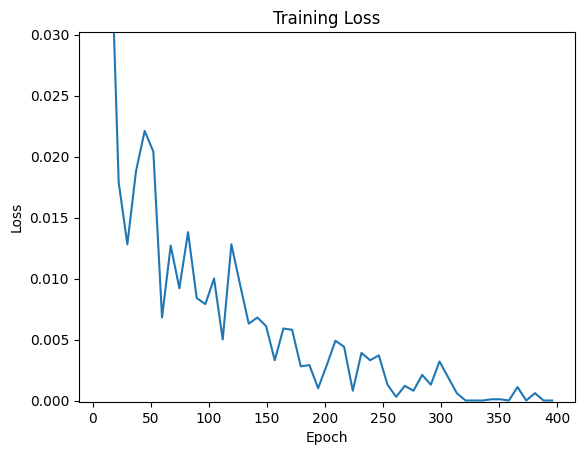

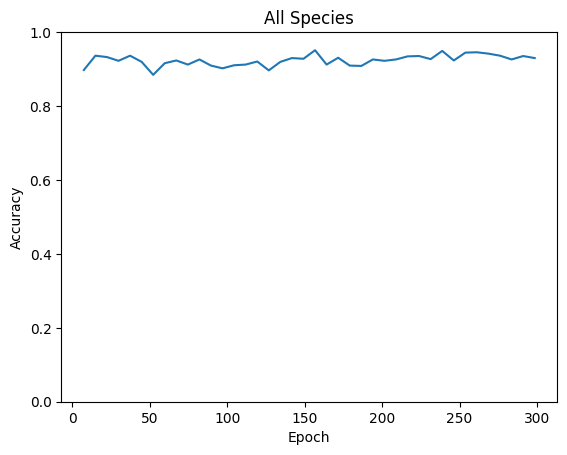

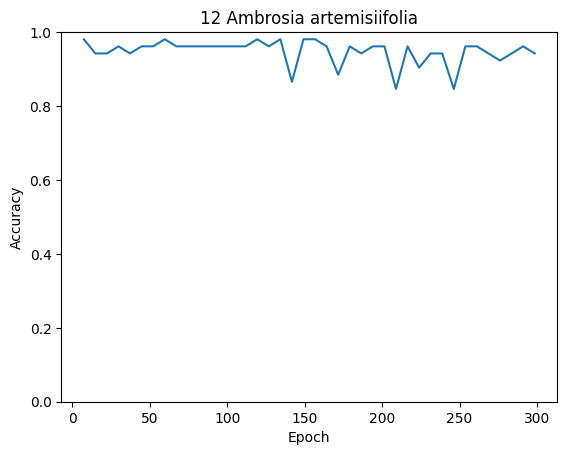

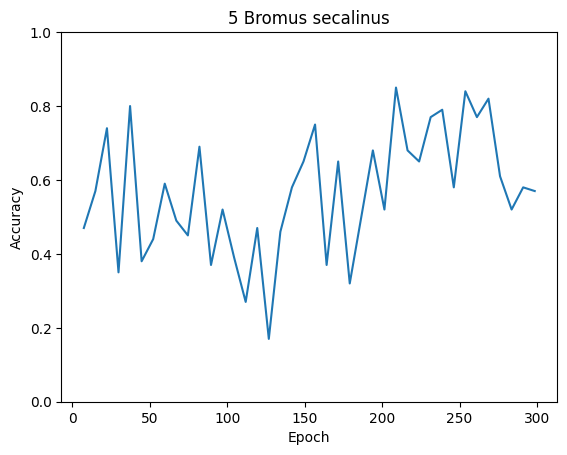

In [ ]:
def main():
    root_path = "../models/15spp_zoom_level_validation_models/1_seed_model_20250127"
    classification_reports = load_classification_reports(root_path)
    state_path = root_path + "/trainer_state.json"
    train_state_df = train_state_to_df(state_path)
    plot_loss(train_state_df)
    plot_accuracy(
        all_spp_accuracy(classification_reports), train_state_df, "All Species"
    )
    plot_class_accuracy(
        classification_reports, train_state_df, "12 Ambrosia artemisiifolia"
    )
    plot_class_accuracy(classification_reports, train_state_df, "5 Bromus secalinus")

    # print(f"Loaded {len(classification_reports)} classification reports")
    # for file_name, report in classification_reports.items():
    #     print(f"File: {file_name}")
    #     print(json.dumps(report, indent=4))
    #     print("\n\n")
    #     break
    # print(json.dumps(classification_reports['500'], indent=4))

    # all_spp_accuracy_df = all_spp_accuracy(classification_reports)
    # print(all_spp_accuracy_df)

    # print(train_state_df)


main()